#CM30320 - Part A, Sentiment Analysis

## Step 1 - Analysing the Task, Defining the Framework

This project involves sentiment analysis, which is concerned with the automated identification of the opinion polarity associated with a peice of text. For example, determining whether a piece of text is positive or negative. In this project, we are provided with a set of reviews extracted from the Internet Movie Database (IMDb) with various polarity labels, and the tsak is to develop an application that can detect whether a review is positive or negative.

This is clearly a binary classification task, and we will solve it using a machine learning approach.




## Step 2 - Preprocessing Data, Inspecting & Gathering Insights

The second step in the NLP pipeline involves preprocessing our data (splitting the data into a training, development, and test set, storing the reviews and labels as separate structures) and applying tokenization here on our word files to look at the individual words contained for each review.

### 2.1 The Dataset - IMDb Reviews, Reading in the Data

The dataset is a subset of 2000 positive and 2000 negative movie reviews extracted from IMDb. The reviews are stored move_data, which will need to be uploaded to the files in google colab (or placed in the same directory if working locally). If in google colab, we can unzip the files first:

In [ ]:
!unzip movie_data.zip

The original dataset is from https://ai.stanford.edu/~amaas/data/sentiment/ , and has over 25,000 highly polar movie reviews for training, and 25,000 for testing. The file naming conventions are as follows: id_star.txt. For example, 13_7.txt represents a review of id 13, which has been given 7 out of 10 stars.
The data is summed up, then, as follows:
- 2000 positive reviews, and 2000 negative reviews
- Each text file name is in the form id_star.txt
- Each text file contains the contents of the review

First, we should try and read in the data appropriately. We'll keep them separate at first. We'll initially read in the data as a mapping (dictionary) between the file name and its contents: {file_name: contents}

In [ ]:
import os

def read_reviews(is_positive_reviews):
    current_directory = os.getcwd()
    review_folder_name = "pos" if is_positive_reviews else "neg"
    review_folder_path = os.path.join(current_directory, "movie_data", review_folder_name)
    review_files = os.listdir(review_folder_path)
    reviews = {}

    for review_file_name in review_files:
        review_file_path = os.path.join(review_folder_path, review_file_name)
        with open(review_file_path) as review_file:
                reviews[review_file_name] = review_file.read()

    return reviews

positive_reviews = read_reviews(is_positive_reviews = True)
negative_reviews = read_reviews(is_positive_reviews = False)

In [ ]:
print(len(positive_reviews))
print(positive_reviews['14_10.txt'])
print(len(negative_reviews))

2000
This film has a special place in my heart, as when I caught it the first time, I was teaching adult literacy. It rang very true to me and even an outstanding student I had at the time. There are scenes which make you gulp with sudden emotion, and those which even put a smile on your face through sheer identification with the characters and their situation. <br /><br />Excellent performances by Jane Fonda and Robert DeNiro that rank with their best work, a great turn by a young Martha Plimpton, an inspiring story line, and a haunting musical score makes for a most enjoyable and rewarding experience.
2000


### 2.2 Splitting Data and Labels into Separate Data Structure

Next we want to store the reviews and labels as separate data structures. I'm disregarding the file names at this point, since they are not providing essential information, and we are not particularly interesting in using the stars given as a feature. (Though classifying a review to a certain number of stars might be an interesting task). From this point forward, we will represent:
1. The Positive Reviews with a label of 1.
2. The Negative Reviews with a label of 0.

We will simply first store a lists of tuples for all of the data [(label, review)]

In [ ]:
# Let's just add the data into one big dataset of positive and negative reviews.

all_reviews = [(1, review) for review in positive_reviews.values()]
all_reviews += [(0, review) for review in negative_reviews.values()]

print("Dataset Size: ", len(all_reviews))

Dataset Size:  4000


Lastly, we'll need to separate these out into two different structures for the review and the label, and then we will want to split our data into the a training, development and test set. We can use sklearn's built-in function for this.

In [ ]:
import sklearn
from sklearn.model_selection import train_test_split

# We'll need to separate the content and the labels before using train_test_split.
reviews = [review for (_,review) in all_reviews]
labels = [label for (label,_) in all_reviews]


# We can split the data now into two parts, training and test data. Random_state here ensures reproducability.
X_train, X_test, y_train, y_test = train_test_split(reviews, labels, test_size=0.2, random_state=42)

# We can split this again into a training and dev set.
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=0.20, random_state=42)

Let's sanity check that these are exactly as we would expect. From above, we want expect 20% of our data to be used for our test set (800 elements), and then the leftover 3200 elements for the training data has been further split into 80% training (2560 elements), and 20% for development (640) elements. In summary, of our dataset of 4000 elements:

- 64% for Training Set
- 16% for Development Set
- 20% for Testing Set

In [ ]:
print("Training Set Shape:", len(X_train), len(y_train))
print("Development Set Shape", len(X_dev), len(y_dev))
print("Testing Set Shape:", len(X_test), len(y_test))

Training Set Shape: 2560 2560
Development Set Shape 640 640
Testing Set Shape: 800 800


We should also check that the proportions of positive and negative reviews are the same across classes.

In [ ]:
# Code Taken from the Week 4 Lab, Author Profiling
def category_proportions(label_data, category):
    count = 0
    for label in label_data:
        if label == category:
            count += 1
    return float(count) / float(len(label_data))

categories = [1,0]
rows = []
rows.append(['Category',"Overall","Training Set", "Development Set", "Testing Set"])
for category in categories:
    rows.append([category, f"{category_proportions(labels, category):.6f}",
                f"{category_proportions(y_train, category):.6f}",
                f"{category_proportions(y_dev, category):.6f}",
                f"{category_proportions(y_test, category):.6f}"])

# The code to display the above in table-format only works when the class labels are strings.
rows[1][0] = '1'
rows[2][0] = '0'

columns = zip(*rows)
column_widths = [max(len(item) for item in col) for col in columns]
for row in rows:
     print(''.join(' {:{width}} '.format(row[i], width=column_widths[i])
                for i in range(0, len(row))))

 Category  Overall   Training Set  Development Set  Testing Set 
 1         0.500000  0.494922      0.485938         0.527500    
 0         0.500000  0.505078      0.514062         0.472500    


## Step 3 - Defining Relevant Information, Selecting & Extracting Features

Really, inspecting and getting insights into our data is a part of step 2 in the basic NLP Pipeline, but we will discuss that all as a third step before we extract different features from our data.

### 3.1 Inspecting and Getting Insights (StopWords)

No matter how we generate our features, we will need to break our reviews down into individual language units first. This is a process known as tokenization. For our task, this will be splitting the reviews into individual words, and then all other processing steps to get our features will start from tokenized words. We can use NLTK's built in tokenizer to try this, and then inspect the data for insight.

In [ ]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

tokenized_training_data = [word_tokenize(review) for review in X_train]

# Sanity Checking
print(type(tokenized_training_data))
print(len(tokenized_training_data))
print(tokenized_training_data[0:2])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


<class 'list'>
2560
[['Written', 'and', 'acted', 'by', 'sincere', 'amateurs', ',', 'produced', 'by', 'some', 'exploitation', 'monger', ',', 'this', 'is', 'dull', 'and', 'hard', 'to', 'watch.', '<', 'br', '/', '>', '<', 'br', '/', '>', 'Not', 'the', 'worst', 'movie', 'ever', ',', 'but', 'at', 'least', 'schlock', 'like', '_Plan', '9', 'From', 'Outer', 'Space_', 'usually', 'had', 'a', 'real', 'actor', 'or', 'two', '.', 'I', "'d", 'recommend', '_A', 'Thief', 'In', 'The', 'Night_', 'only', 'to', 'hardcore', 'ironists', 'and', 'hardcore', 'Dispensationalists', '.', 'I', "'m", 'neither.', '<', 'br', '/', '>', '<', 'br', '/', '>', 'Do', "n't", 'believe', 'me', '?', 'Watch', 'it', 'for', 'free', '(', 'albeit', 'sourced', 'from', 'poor', 'VHS', ')', 'here', ':', 'http', ':', '//www.archive.org/details/Thief-In-The-Night', '<', 'br', '/', '>', '<', 'br', '/', '>', 'Relevant', 'links', 'added', 'mostly', 'to', 'reach', 'IMDb', "'s", '10-line', 'minimum', ':', 'http', ':', '//en.wikipedia.org/wiki/

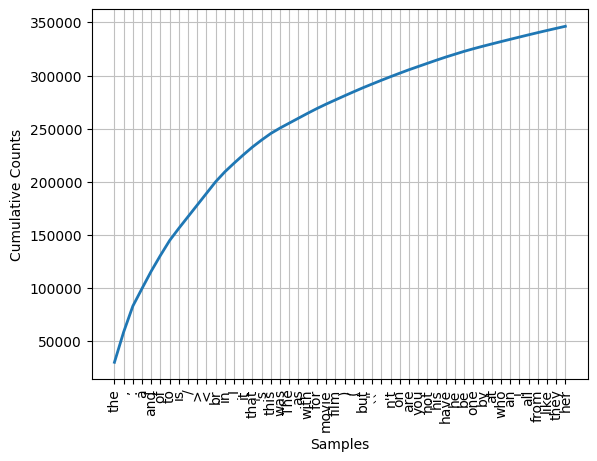

<Axes: xlabel='Samples', ylabel='Cumulative Counts'>

In [ ]:
from itertools import chain
from nltk.probability import FreqDist

# A list of every word used in the reviews
all_words_across_reviews = list(chain(*tokenized_training_data))

word_freq_distribution = FreqDist(all_words_across_reviews)
word_freq_distribution.plot(50, cumulative=True)

In [ ]:
top_50_words = word_freq_distribution.most_common(50) # Returns [(a,b)] where a is the word and b is the count
top_50_word_counts = sum(count for (word,count) in top_50_words)
total_word_count = len(all_words_across_reviews)
top_50_words_percentage = (top_50_word_counts/total_word_count)*100
print(f"Percentage of Words That Are Covered by the Top 50 Words: {top_50_words_percentage:.2f}%")

Percentage of Words That Are Covered by the Top 50 Words: 46.90%


We can clearly see from above the most common words are not very information, and are mainly stopwords: 'the', 'a', 'on' etc. Such words will not be very helpful in finding whether a review is positive or negative. They are also cover 46.85% of all the words. We will be able to process our data much quicker, without losing useful information, if we remove these words for our dataset.  

### 3.2 Setup to Generate Features

Above, we saw that words that do not give much meaning cover approximately 46.85% of all the words (across every review). It is also noteable that a lot of these words are actually just punctuation. When generating features, we will always be:
- Tokenzing
- Removing stopwords, Lowercasing, Removing Punctuation

#### 3.2.1 CountVectorizer()

CountVectorizer() is a useful feature extraction method provided by sklearn, with the documentation found [here.](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). The below is directly from the documentation:

CountVectorizer will convert a collection of text documents to a matrix of token counts. It will produce a sparse representation of the counts using a scipy.sparse.csr_matrix.

Note that a sparce matrix is a matrix in where most of the elements are 0. The csr_matrix provides us with fast row slicing, and faster matrix vector product operations. When printing a sparse matrix out we will get something like the following (info from [here](https://www.w3schools.com/python/scipy/scipy_sparse_data.php)):

(0, 5)	1 <br>
(0, 6)	1 <br>
(0, 8)	2 <br>

Each line corresponds to a non-zero element. The (i, j) references the i row, j column, which will have a value (count) of the number following the brackets.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# CountVectorizer will automatically tokenize the data, and is, by default, not removing stopwords or punctuation.
vectorizer = CountVectorizer()
training_feature_matrix = vectorizer.fit_transform(X_train)
print(training_feature_matrix.shape)

(2560, 28976)


#### 3.2.2 Stemming, Lemmatisation

CountVectoriser does not provide a default way to include stemming/lemmatization in the tokenization process. One way to include stemming would be to create our own tokenizer, which is exactly what we will do:

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer
from nltk.stem import WordNetLemmatizer
import string

# CountVectorizer's tokenizer is expected to take in one piece of text as an input, and will return a list of tokens.
# We will need our tokenizer methods to follow this behaviour

def tokenize_and_stem_document(document):
   stoplist = set(stopwords.words('english'))
   ls = LancasterStemmer()
   tokenized_word_list = [ls.stem(word) for word in word_tokenize(document.lower())
                      if word.isalpha() and not word in stoplist and not word in string.punctuation]
   return tokenized_word_list

def tokenize_and_lemmatize_document(document):
    stoplist = set(stopwords.words('english'))
    lem = WordNetLemmatizer()
    tokenized_word_list = [lem.lemmatize(word) for word in word_tokenize(document.lower())
                            if word.isalpha() and not word in stoplist and not word in string.punctuation]
    return tokenized_word_list

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


#### 3.2.3 Implementing TF-IDF Normalisation from CountVectorizer

Lastly, we will want to consider how we want to normalise our data. The specifics of this requirement require normalising the data without using sklearn's TfidfVectorizer. We can, however, just normalize the data ourselves using the result of countvectorizer.

In [ ]:
import numpy as np

# Expects numpy array (document_term matrix) of the shape (x_samples, n_features)
def tfidf_normalization(document_term_matrix):
  # Calculating TF: tf(term) = count of term in a document / count of all terms in a document.
  document_term_counts = document_term_matrix.sum(axis=1)
  tf = document_term_matrix / document_term_counts[:, np.newaxis]

  # Calculating IDF: df(term) = log((no. of documents in dataseet / (no.of documents that contain the term+1))
  number_of_documents = document_term_matrix.shape[0]
  df = np.count_nonzero(document_term_matrix, axis=0) + 1
  idf = np.log(number_of_documents / df)

  tf_idf = tf * idf
  return tf_idf

### 3.3 Generating Features

Now, we can appropriately generate our set of features using CountVectorizer with our own tokenization methods, as well as using TF-IDF to normalize the data. Each feature set will be generated, initially, by tokenization, removing stop words and punctuation. From there, we differentiate between how features are generated from using lemmatization or stemming, different n-grams etc.

#### 3.3.1 Feature Set 1 - Lemmatization, 1-Grams, TF-IDF Normalization

In [ ]:
from scipy import sparse

lemmatize_onegrams_vectorizer = CountVectorizer(tokenizer=tokenize_and_lemmatize_document)
feature_set_1_term_counts = lemmatize_onegrams_vectorizer.fit_transform(X_train)
feature_set_1 = tfidf_normalization(feature_set_1_term_counts.toarray())

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


#### 3.3.3 Feature Set 2 - Lemmatization, 1 Grams and 2-Grams, TF-IDF Normalization

In [ ]:
lemmatize_twograms_vectorizer = CountVectorizer(tokenizer=tokenize_and_lemmatize_document, ngram_range=(1, 2))
feature_set_2_term_counts = lemmatize_twograms_vectorizer.fit_transform(X_train)
feature_set_2 = tfidf_normalization(feature_set_2_term_counts.toarray())

#### 3.3.4 Feature Set 3 - Lemmatization, 3-Grams, TF-IDF Normalization

In [ ]:
lemmatize_threegrams_vectorizer = CountVectorizer(tokenizer=tokenize_and_lemmatize_document, ngram_range=(1,3))
feature_set_3_term_counts = lemmatize_threegrams_vectorizer.fit_transform(X_train)
feature_set_3 = tfidf_normalization(feature_set_3_term_counts.toarray())

## Step 4 - Selecting & Implementing Appropriate Algorithm for Task (Training & Testing)

### 4.1 Naive Bayes - Personal Implementation

In [ ]:
import numpy as np

# Class Description
  # A Naive Bayes Classifier implementation that assumes binary labels.
  # X_Train - a numpy array (document_term matrix) of the shape (n_samples, n_features)
  # Y_Train - a numpy array of shape (n_samples,), which correspond to the labels of the respective rows in X_train
  # X_Test  - a numpy array (document_term matrix) of the shape (x_samples, n_features)

class NaiveBayesClassifier:
  def __init__(self):
    self.class_labels = [0,1]
    self.prior_probabilities = [0,0]
    self.feature_likelihoods = None

  def train(self, X_train, Y_train, alpha=1):
    self.__calculate_prior_probabilities__(Y_train)
    self.__calculate_feature_likelihoods__(X_train, Y_train, alpha)

  def __calculate_prior_probabilities__(self, Y_train):
    training_data_size = len(Y_train)
    self.prior_probabilities[0] = np.log(np.count_nonzero(Y_train == 0) / training_data_size)
    self.prior_probabilities[1] = np.log(np.count_nonzero(Y_train == 1) / training_data_size)

  def __calculate_feature_likelihoods__(self, X_train, Y_train, alpha):
    num_of_features = X_train.shape[1]

    # Shape of (2, num_of_features), with self.feature_likelihoods[i][j] representing p(feature j | class i)
    self.feature_likelihoods = np.zeros((len(self.class_labels), num_of_features))

    for class_label in self.class_labels:
      instances_of_class_label = X_train[Y_train == class_label]
      feature_counts_along_documents = np.sum(instances_of_class_label, axis=0)  + alpha
      total_number_of_features = np.sum(instances_of_class_label) + (alpha)*(num_of_features)
      self.feature_likelihoods[class_label, :] = np.log(feature_counts_along_documents / total_number_of_features)

  def predict(self, X_test):
    predictions = []
    for document in X_test:
      class_probabilities = [self.prior_probabilities[0], self.prior_probabilities[1]]
      for class_label in self.class_labels:
        for feature_index, feature_count in enumerate(document):
          class_probabilities[class_label] += feature_count * self.feature_likelihoods[class_label, feature_index]
      predictions.append(np.argmax(class_probabilities))
    return predictions

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

def evaluate_predictions(actual_labels, predicted_labels, feature_set_name):
  print("Overview of Results For: ", feature_set_name)
  accuracy = accuracy_score(actual_labels, predicted_labels) # No. of Times Correct Overall
  precision = precision_score(actual_labels, predicted_labels) # How Trustworthy is the model? TP/TP+FP
  recall = recall_score(actual_labels, predicted_labels) # Coverage, How many of the Positives did we label correctly? TP / TP + FN
  f1 = f1_score(actual_labels, predicted_labels) # Balance between precision and recall.

  print(f"Accuracy: {accuracy:.4f}")
  print(f"Precision: {precision:.4f}")
  print(f"Recall: {recall:.4f}")
  print(f"F1: {f1:.4f}")

  cm = confusion_matrix(actual_labels, predicted_labels)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm)
  disp.plot()

### 4.2 Training Personal Naive Bayes & Sklearn's Multinomial Naive Bayes on Feature Set & Testing on Development Set

In [ ]:
from sklearn.naive_bayes import MultinomialNB
multinomial_nb = MultinomialNB()
personal_nb = NaiveBayesClassifier()

y_train_np = np.array(y_train)

#### 4.2.1 Feature Set 1 Evaluation

In [ ]:
X_dev_transformed_fs1 = lemmatize_onegrams_vectorizer.transform(X_dev)
X_dev_normalised_fs1 = tfidf_normalization(X_dev_transformed_fs1.toarray())

Overview of Results For:  Feature Set 1 - Personal Implementation
Accuracy: 0.8187
Precision: 0.8598
Recall: 0.7492
F1: 0.8007


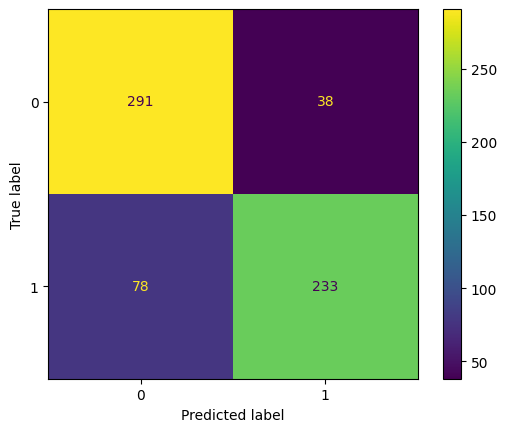

In [ ]:
personal_nb.train(feature_set_1, y_train_np)
personal_nb_predictions_fs1 = personal_nb.predict(X_dev_normalised_fs1)
evaluate_predictions(y_dev ,personal_nb_predictions_fs1, "Feature Set 1 - Personal Implementation")

Overview of Results For:  Feature Set 1 - Sklearn Implementation
Accuracy: 0.8187
Precision: 0.8598
Recall: 0.7492
F1: 0.8007


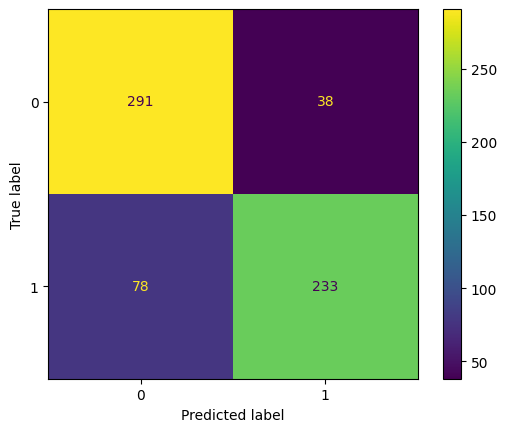

In [ ]:
multinomial_nb.fit(feature_set_1, y_train_np)
multinomial_predicitons_fs1 = multinomial_nb.predict(X_dev_normalised_fs1)
evaluate_predictions(y_dev ,multinomial_predicitons_fs1, "Feature Set 1 - Sklearn Implementation")

#### 4.2.2 Feature Set 2 Evaluation

In [ ]:
X_dev_transformed_fs2 = lemmatize_twograms_vectorizer.transform(X_dev)
X_dev_normalised_fs2 = tfidf_normalization(X_dev_transformed_fs2.toarray())

Overview of Results For:  Feature Set 2 - Personal Implementation
Accuracy: 0.8250
Precision: 0.8902
Recall: 0.7299
F1: 0.8021


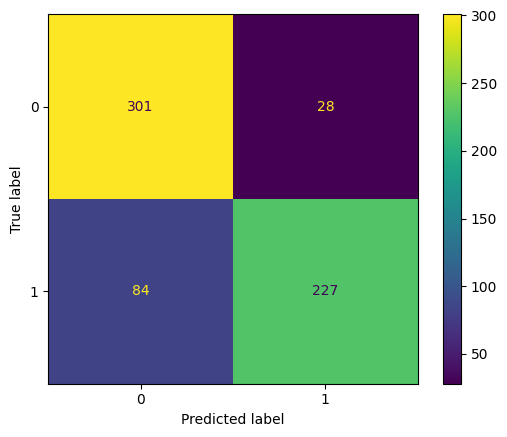

In [ ]:
personal_nb.train(feature_set_2, y_train_np)
personal_nb_predictions_fs2 = personal_nb.predict(X_dev_normalised_fs2)
evaluate_predictions(y_dev, personal_nb_predictions_fs2, "Feature Set 2 - Personal Implementation")

Overview of Results For:  Feature Set 2 - Sklearn Implementation
Accuracy: 0.8250
Precision: 0.8902
Recall: 0.7299
F1: 0.8021


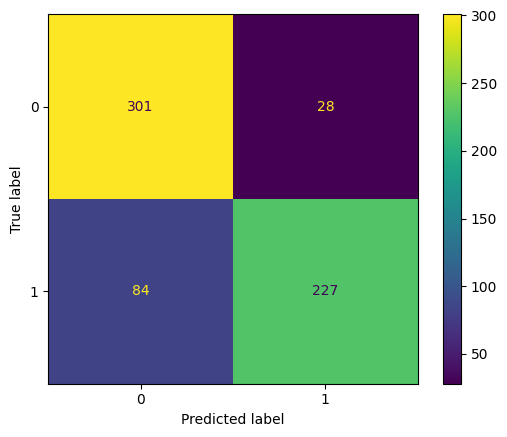

In [ ]:
multinomial_nb.fit(feature_set_2, y_train_np)
multinomial_nb_predictions_fs2 = multinomial_nb.predict(X_dev_normalised_fs2)
evaluate_predictions(y_dev, multinomial_nb_predictions_fs2, "Feature Set 2 - Sklearn Implementation")

#### 4.2.3 Feature Set 3 Evaluation

In [ ]:
X_dev_transformed_fs3 = lemmatize_threegrams_vectorizer.transform(X_dev)
X_dev_normalised_fs3 = tfidf_normalization(X_dev_transformed_fs3.toarray())

Overview of Results For:  Feature Set 3 - Personal Implementation
Accuracy: 0.8094
Precision: 0.8921
Recall: 0.6913
F1: 0.7790


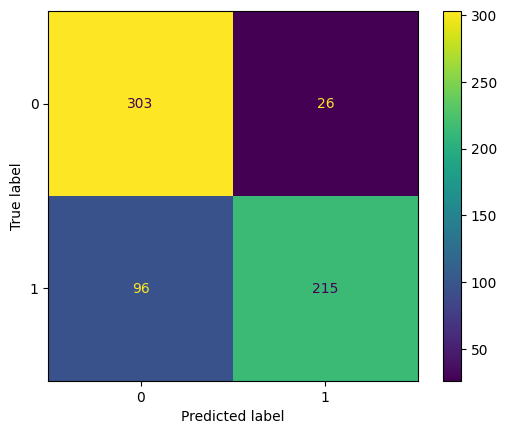

In [ ]:
personal_nb.train(feature_set_3, y_train_np)
personal_nb_predictions_fs3 = personal_nb.predict(X_dev_normalised_fs3)
evaluate_predictions(y_dev, personal_nb_predictions_fs3, "Feature Set 3 - Personal Implementation")

Overview of Results For:  Feature Set 3 - Sklearn Implementation
Accuracy: 0.8094
Precision: 0.8921
Recall: 0.6913
F1: 0.7790


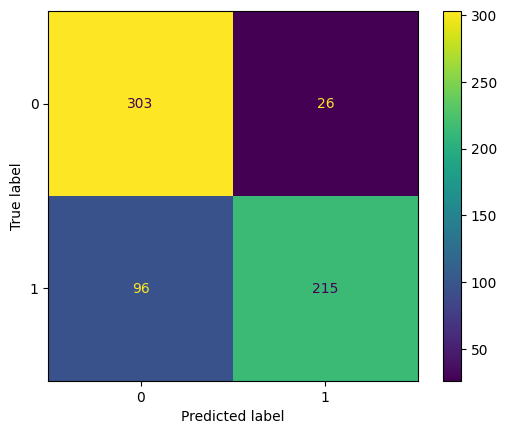

In [ ]:
multinomial_nb.fit(feature_set_3, y_train_np)
multinomial_nb_predictions_fs3 = multinomial_nb.predict(X_dev_normalised_fs3)
evaluate_predictions(y_dev, multinomial_nb_predictions_fs3, "Feature Set 3 - Sklearn Implementation")

### 4.3 Evaluation of Best Feature Set on Test Set

In [ ]:
X_test_transformed = lemmatize_twograms_vectorizer.transform(X_test)
X_test_normalized = tfidf_normalization(X_test_transformed.toarray())

Overview of Results For:  Test Set - Personal Implementation
Accuracy: 0.8087
Precision: 0.9039
Recall: 0.7133
F1: 0.7974


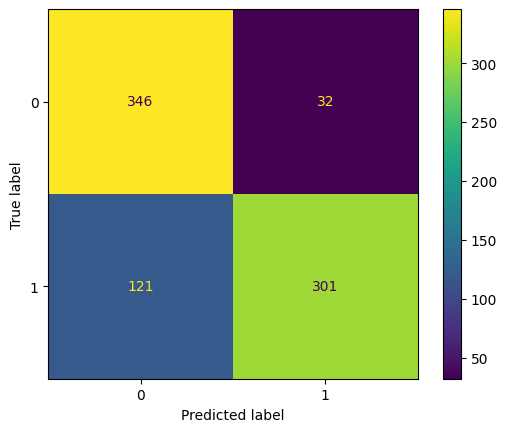

In [ ]:
personal_nb.train(feature_set_2, y_train_np)
predicted_test_labels = personal_nb.predict(X_test_normalized)
evaluate_predictions(y_test, predicted_test_labels, "Test Set - Personal Implementation")

Overview of Results For:  Test Set - Sklearn Implementation
Accuracy: 0.8087
Precision: 0.9039
Recall: 0.7133
F1: 0.7974


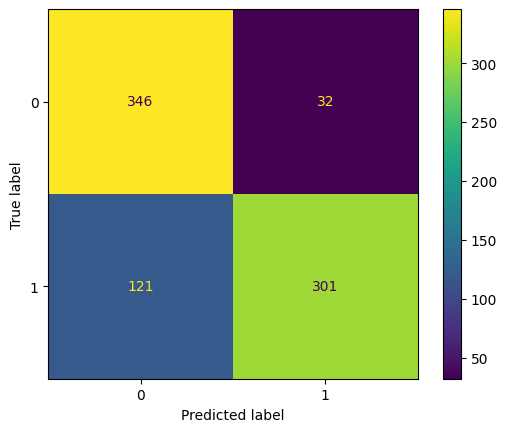

In [ ]:
multinomial_nb.fit(feature_set_2, y_train_np)
predicted_test_labels_multinomialnb = multinomial_nb.predict(X_test_normalized)
evaluate_predictions(y_test, predicted_test_labels_multinomialnb, "Test Set - Sklearn Implementation")

## Step 5 - Exploring Sklearn's Built-In Models: SGD Based Classification and SVMs

### 5.1 Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
# All parameters will just be set to default.
logistic_reg = LogisticRegression()

#### 5.1.1 Feature Set 1 Evaluation

Overview of Results For:  Feature Set 1 - Logistic Regression
Accuracy: 0.8187
Precision: 0.8176
Recall: 0.8071
F1: 0.8123


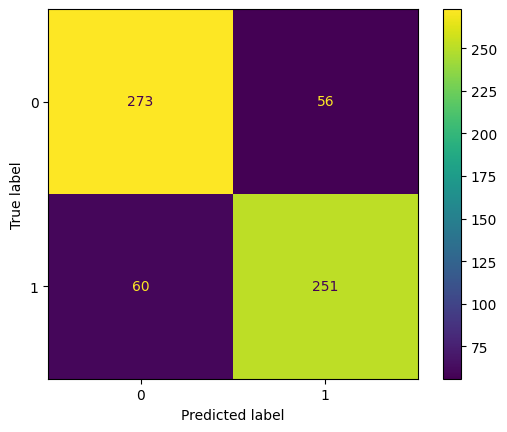

In [ ]:
logistic_reg.fit(feature_set_1, y_train_np)
logistic_reg_predicitons_fs1 = logistic_reg.predict(X_dev_normalised_fs1)
evaluate_predictions(y_dev ,logistic_reg_predicitons_fs1, "Feature Set 1 - Logistic Regression")

#### 5.1.2 Feature Set 2 Evaluation

Overview of Results For:  Feature Set 2 - Logistic Regression
Accuracy: 0.8219
Precision: 0.8505
Recall: 0.7685
F1: 0.8074


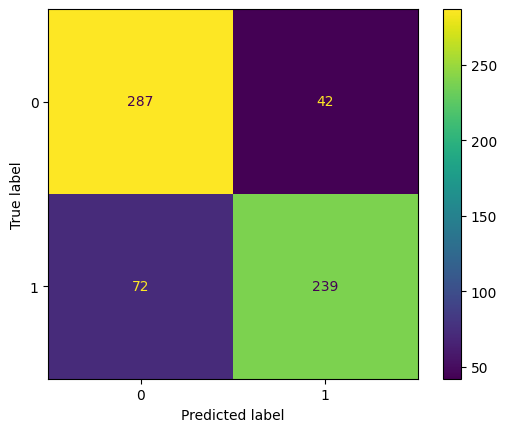

In [ ]:
logistic_reg.fit(feature_set_2, y_train_np)
logistic_reg_predicitons_fs2 = logistic_reg.predict(X_dev_normalised_fs2)
evaluate_predictions(y_dev ,logistic_reg_predicitons_fs2, "Feature Set 2 - Logistic Regression")

#### 5.1.3 Feature Set 3 Evaluation

Overview of Results For:  Feature Set 3 - Logistic Regression
Accuracy: 0.8203
Precision: 0.8858
Recall: 0.7235
F1: 0.7965


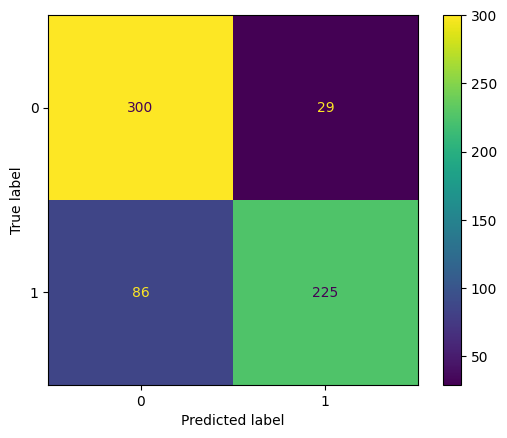

In [ ]:
logistic_reg.fit(feature_set_3, y_train_np)
logistic_reg_predicitons_fs3 = logistic_reg.predict(X_dev_normalised_fs3)
evaluate_predictions(y_dev ,logistic_reg_predicitons_fs3, "Feature Set 3 - Logistic Regression")

#### 5.1.4 Hyperparamter Optimisation with Feature Set 2


Looking at sklearn's documentation, there is no critical hyperparameter to tune. Examples of the hyperparameters to tune include:
- Penalty, specifying the type of regularization to be applied.
- C, the inverse of regularization strength. A higher C value results in less regularization.
- Solver, the algorithm used for optimization

The default values include:
- Solver: lbfgs
- C: 1
- Penalty: l2

In [ ]:
def log_reg_hyperparameters_trial(X_train, Y_train, X_dev, Y_dev, C=1, solver='lbfgs', penalty='l2'):
  log_reg = LogisticRegression(C=C, solver=solver, penalty=penalty)
  log_reg.fit(X_train, Y_train)
  predictions = log_reg.predict(X_dev)
  evaluate_predictions(Y_dev ,predictions, "Hyperparamter Tuning - Logistic Regression")

##### **5.1.4.1 Changing Solvers**

Overview of Results For:  Hyperparamter Tuning - Logistic Regression
Accuracy: 0.8219
Precision: 0.8505
Recall: 0.7685
F1: 0.8074


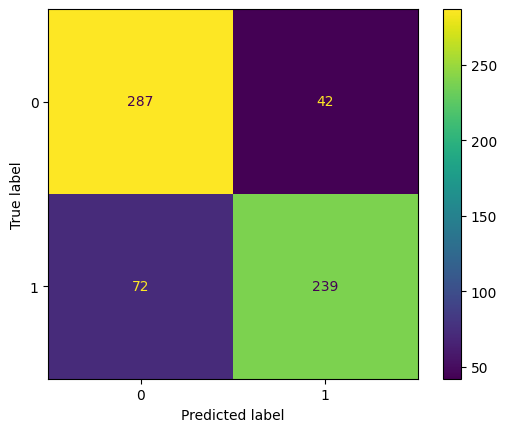

In [ ]:
log_reg_hyperparameters_trial(feature_set_2, y_train_np, X_dev_normalised_fs2, y_dev,
                              C=1, solver='newton-cg', penalty='l2')

Overview of Results For:  Hyperparamter Tuning - Logistic Regression
Accuracy: 0.8219
Precision: 0.8505
Recall: 0.7685
F1: 0.8074


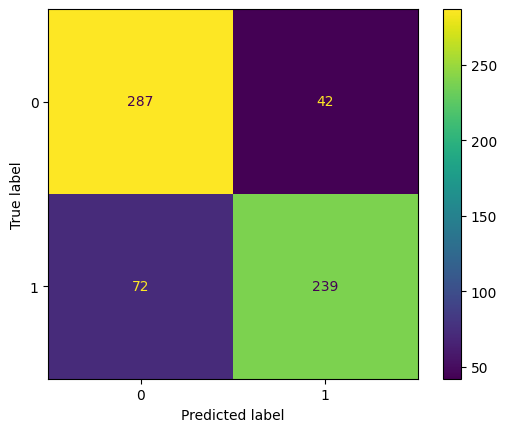

In [ ]:
log_reg_hyperparameters_trial(feature_set_2, y_train_np, X_dev_normalised_fs2, y_dev, C=1, solver='sag', penalty='l2')

Overview of Results For:  Hyperparamter Tuning - Logistic Regression
Accuracy: 0.8219
Precision: 0.8505
Recall: 0.7685
F1: 0.8074


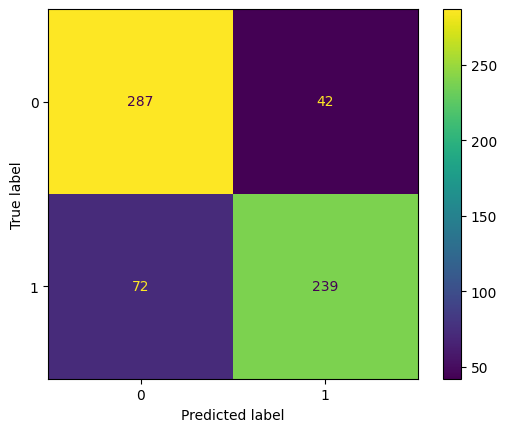

In [ ]:
log_reg_hyperparameters_trial(feature_set_2, y_train_np, X_dev_normalised_fs2, y_dev, C=1, solver='saga', penalty='l2')

Overview of Results For:  Hyperparamter Tuning - Logistic Regression
Accuracy: 0.6281
Precision: 0.5765
Recall: 0.8842
F1: 0.6980


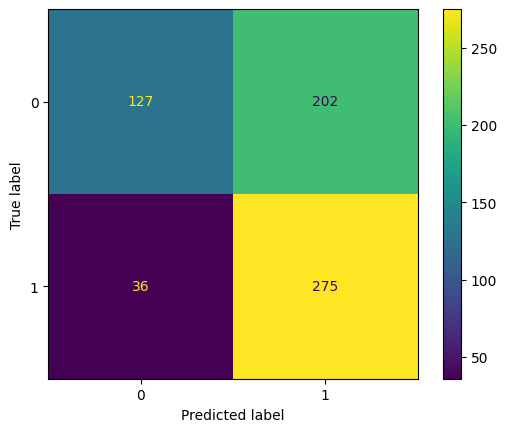

In [ ]:
log_reg_hyperparameters_trial(feature_set_2, y_train_np, X_dev_normalised_fs2, y_dev, C=1, solver='liblinear', penalty='l1')

##### **5.1.4.2 Changing C**

Overview of Results For:  Hyperparamter Tuning - Logistic Regression
Accuracy: 0.8359
Precision: 0.8388
Recall: 0.8199
F1: 0.8293


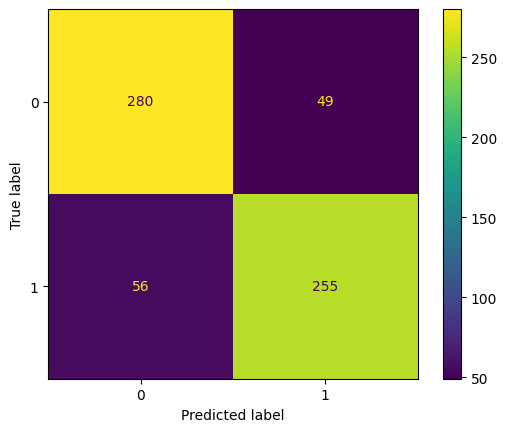

In [ ]:
log_reg_hyperparameters_trial(feature_set_2, y_train_np, X_dev_normalised_fs2, y_dev, C=100, solver='lbfgs', penalty='l2')

#### 5.1.5 Evaluation of Test Set

Overview of Results For:  Test Set - Logistic Regression
Accuracy: 0.8650
Precision: 0.8829
Recall: 0.8578
F1: 0.8702


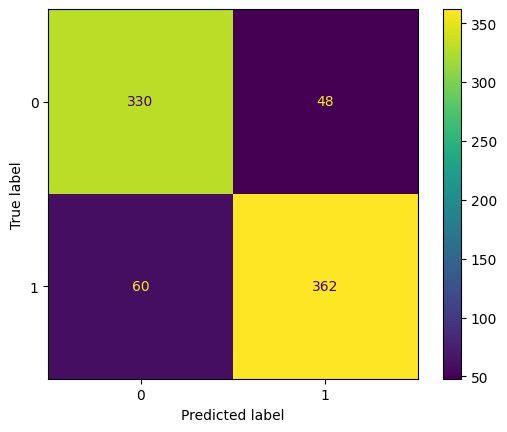

In [ ]:
log_reg = LogisticRegression(C=100, solver='lbfgs', penalty='l2')
log_reg.fit(feature_set_2, y_train_np)
predicted_test_labels_log_reg = log_reg.predict(X_test_normalized)
evaluate_predictions(y_test, predicted_test_labels_log_reg , "Test Set - Logistic Regression")

### 5.2 Support Vector Machines (SVMs)

In [ ]:
from sklearn import svm
svm_model = svm.SVC()

#### 5.2.1 Feature Set 1 Evaluation

In [ ]:
svm_model.fit(feature_set_1, y_train_np)

SVC()

Overview of Results For:  Feature Set 1 - SVM
Accuracy: 0.8125
Precision: 0.7903
Recall: 0.8360
F1: 0.8125


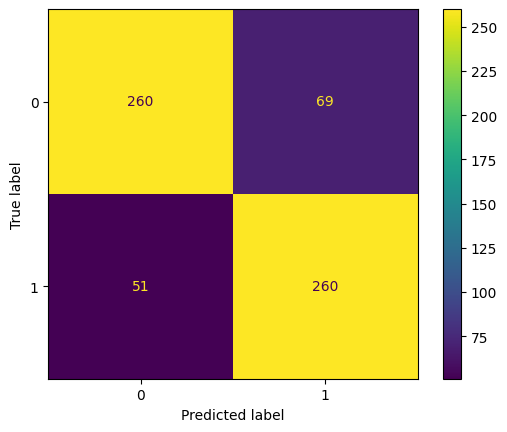

In [ ]:
svm_model.fit(feature_set_1, y_train_np)
svm_model_predicitons_fs1 = svm_model.predict(X_dev_normalised_fs1)
evaluate_predictions(y_dev ,svm_model_predicitons_fs1, "Feature Set 1 - SVM")

#### 5.2.2 Feature Set 2 Evaluation

Overview of Results For:  Feature Set  - SVM
Accuracy: 0.8125
Precision: 0.8131
Recall: 0.7974
F1: 0.8052


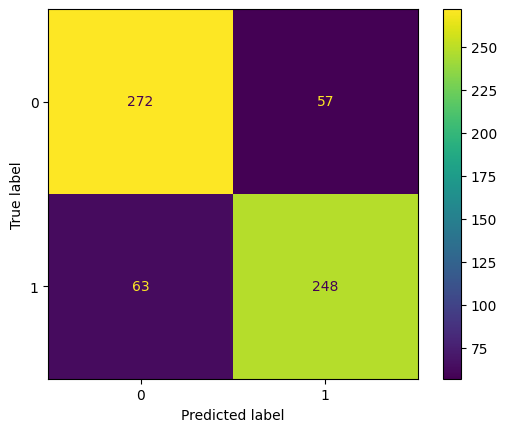

In [ ]:
svm_model.fit(feature_set_2, y_train_np)
svm_model_predicitons_fs2 = svm_model.predict(X_dev_normalised_fs2)
evaluate_predictions(y_dev ,svm_model_predicitons_fs2, "Feature Set  - SVM")

#### 5.2.3 Feature Set 3 Evaluation

Overview of Results For:  Feature Set 3 - SVM
Accuracy: 0.8031
Precision: 0.8223
Recall: 0.7588
F1: 0.7893


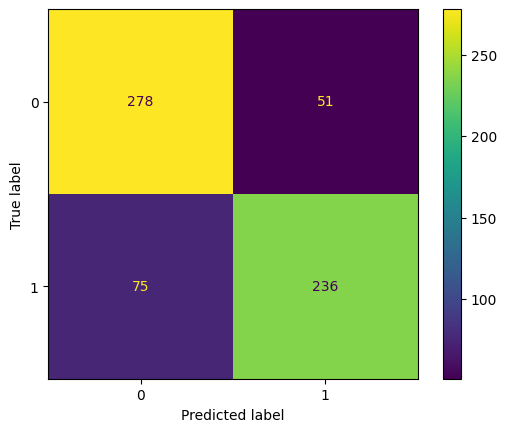

In [ ]:
svm_model.fit(feature_set_3, y_train_np)
svm_model_predictions_fs3 = svm_model.predict(X_dev_normalised_fs3)
evaluate_predictions(y_dev ,svm_model_predictions_fs3, "Feature Set 3 - SVM")

### 5.4 Hyperparameter Optimisation

In [ ]:
def svm_hyperparameters_trial(X_train, Y_train, X_dev, Y_dev, C=1, kernel='rbf', degree=3, gamma='scale'):
  svm_model = svm.SVC(C=C, kernel=kernel, degree=degree, gamma=gamma)
  svm_model.fit(X_train, Y_train)
  predictions = svm_model.predict(X_dev)
  evaluate_predictions(Y_dev , predictions, "Hyperparamter Tuning - SVMs")

Overview of Results For:  Hyperparamter Tuning - SVMs
Accuracy: 0.8250
Precision: 0.8119
Recall: 0.8328
F1: 0.8222


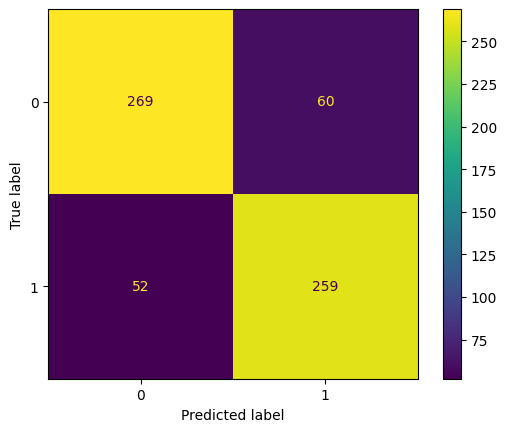

In [ ]:
svm_hyperparameters_trial(feature_set_1, y_train_np, X_dev_normalised_fs1, y_dev,
                              C=1, kernel='sigmoid', degree=3, gamma='scale')

Overview of Results For:  Hyperparamter Tuning - SVMs
Accuracy: 0.7375
Precision: 0.7227
Recall: 0.7460
F1: 0.7342


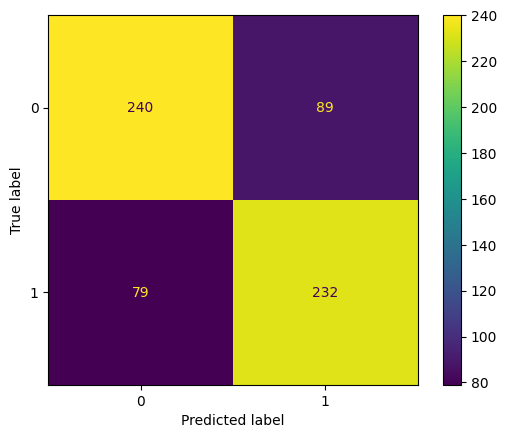

In [ ]:
svm_hyperparameters_trial(feature_set_1, y_train_np, X_dev_normalised_fs1, y_dev,
                              C=100, kernel='sigmoid', degree=3, gamma='scale')

Overview of Results For:  Hyperparamter Tuning - SVMs
Accuracy: 0.5188
Precision: 0.8000
Recall: 0.0129
F1: 0.0253


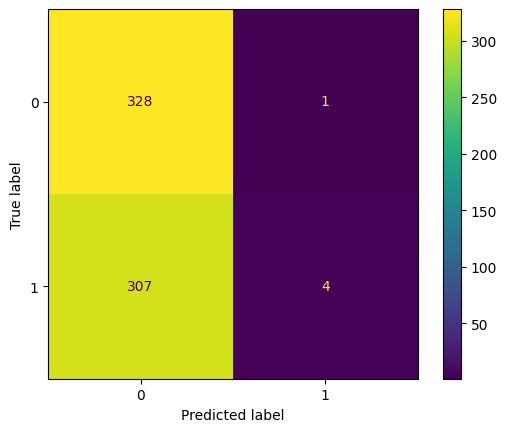

In [ ]:
svm_hyperparameters_trial(feature_set_1, y_train_np, X_dev_normalised_fs1, y_dev,
                              C=1, kernel='poly', degree=3, gamma='scale')

Overview of Results For:  Hyperparamter Tuning - SVMs
Accuracy: 0.8250
Precision: 0.8119
Recall: 0.8328
F1: 0.8222


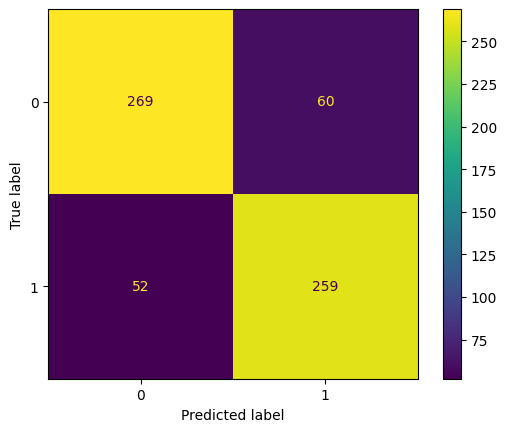

In [ ]:
svm_hyperparameters_trial(feature_set_1, y_train_np, X_dev_normalised_fs1, y_dev,
                              C=1, kernel='sigmoid', degree=5, gamma='scale')

Overview of Results For:  Hyperparamter Tuning - SVMs
Accuracy: 0.6484
Precision: 0.9388
Recall: 0.2958
F1: 0.4499


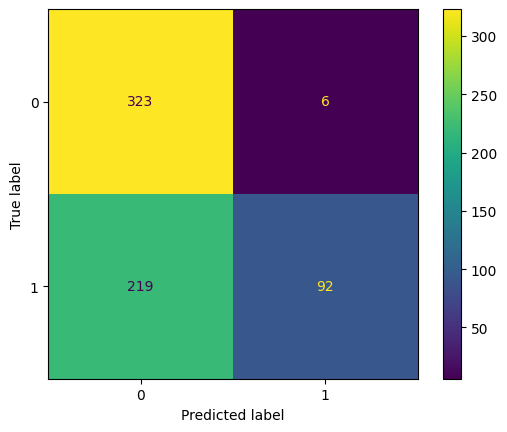

In [ ]:
svm_hyperparameters_trial(feature_set_1, y_train_np, X_dev_normalised_fs1, y_dev,
                              C=0.1, kernel='sigmoid', degree=3, gamma='scale')

### 5.5 Performance on Test Set

Overview of Results For:  Test Set - SVM
Accuracy: 0.8575
Precision: 0.8720
Recall: 0.8555
F1: 0.8636


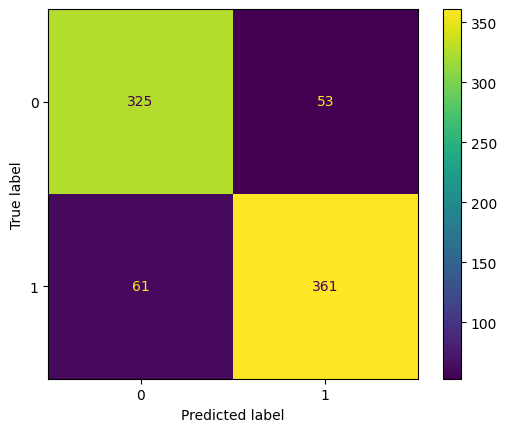

In [ ]:
svm_for_test_set = svm.SVC(C=1, kernel='sigmoid', degree=3, gamma='scale')
svm_for_test_set.fit(feature_set_1, y_train_np)

X_test_transformed_svm = lemmatize_onegrams_vectorizer.transform(X_test)
X_test_normalized_svm = tfidf_normalization(X_test_transformed_svm.toarray())

predicted_test_labels_svm_test = svm_for_test_set.predict(X_test_normalized_svm)
evaluate_predictions(y_test, predicted_test_labels_svm_test , "Test Set - SVM")

# Appendix

Below is my second attempt at implementating the naive bayes classifier using sparse matricses. It is more efficient, and expects X_train to be a sparse matrix, and Y_train to be a numpy array. But, I think it is more confusing to read, and so would need to more optimisation.

In [ ]:
class NaiveBayesClassifier:
  def __init__(self):
    self.class_labels = [0,1]
    self.prior_probabilities = [0,0]
    self.feature_likelihoods = None

  def train(self, X_train, Y_train,alpha=1):
    self.__calculate_prior_probabilities__(X_train, Y_train)
    self.__calculate_feature_likelihoods__(X_train, Y_train,alpha)

  def __calculate_prior_probabilities__(self, X_train, Y_train):
    training_data_size = len(Y_train)
    self.prior_probabilities[0] = np.log(np.count_nonzero(Y_train == 0) / training_data_size)
    self.prior_probabilities[1] = np.log(np.count_nonzero(Y_train == 1) / training_data_size)

  def __calculate_feature_likelihoods__(self, X_train, Y_train, alpha):
    num_of_features = X_train.shape[1]

    # An array list of shape [[0, 0, ... , 0], [0, 0, ... 0]] for storing calculated liklihoods.
    # feature_likelihoods[i][j]] represents the likelihood of feature j appearing in class i.
    self.feature_likelihoods = np.zeros((len(self.class_labels), num_of_features))

    # P(Feature | Class) = (Number of Total Occurences of Feature in Class) / Total Occurences of All Features in Class
    for class_label in self.class_labels:
        instances_of_class_label_in_x = X_train[Y_train == class_label] # Remove instances from the training data not in the class we're looking at
        specific_feature_counts = np.sum(instances_of_class_label_in_x, axis=0) + alpha # (Number of Total Occurences of Feature in Class)
        all_feature_counts = np.sum(instances_of_class_label_in_x) + (alpha)*(num_of_features) # Total Occurences of All Features in Class
        self.feature_likelihoods[class_label, :] = np.log(specific_feature_counts / all_feature_counts)

  def predict(self, X_test):
      predictions = []
      for document in X_test:
          class_probabilities = [self.prior_probabilities[0],self.prior_probabilities[1]]
          for class_label in self.class_labels:
              for index, value in zip(document.indices, document.data):
                  class_probabilities[class_label] += value * (self.feature_likelihoods[class_label,index])
          predictions.append(np.argmax(class_probabilities))
      return predictions